<a href="https://colab.research.google.com/github/vtecftwy/metagenomics/blob/refactor_cnn_virus/nbs/2_02_EC_train_cnn_virus_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train CNN_Virus code with original dataset

Original code is [here](https://github.com/MaHaoran627/CNN_Virus)

If you run this notebook locally, first install the latest version of metagenomics repo in your environment with the following command in the cli:

`pip install -U git+https://github.com/vtecftwy/metagenomics.git@refactor_cnn_virus`

If you run it on Colab, it will be done automatically.

Once this is done, all code can be imported as:
```python
    from src.module_name import object_name
```
Such as:
```python
    from src.architecture import build_model
```

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
try:
    from google.colab import drive
    ON_COLAB = True
    print('Running on colab')
    print('Installing custom project code')   
    !pip install -U git+https://github.com/vtecftwy/metagenomics.git@refactor_cnn_virus
    drive.mount('/content/gdrive')
    p2drive = Path('/content/gdrive/MyDrive/Metagenonics/')
    p2data =  p2drive / 'CNN_Virus_data'

except:
    ON_COLAB = False
    print('Running locally')
    print('Make sure you have installed the custom project code in your environment')
    pdata = Path('data/cnn_virus')

Running on colab
Installing custom project code
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/vtecftwy/metagenomics.git (to revision refactor_cnn_virus) to /tmp/pip-req-build-hfwxpuzn
  Running command git clone -q https://github.com/vtecftwy/metagenomics.git /tmp/pip-req-build-hfwxpuzn
  Running command git checkout -b refactor_cnn_virus --track origin/refactor_cnn_virus
  Switched to a new branch 'refactor_cnn_virus'
  Branch 'refactor_cnn_virus' set up to track remote branch 'refactor_cnn_virus' from 'origin'.
  Created wheel for src: filename=src-1.0.0-py3-none-any.whl size=14692 sha256=4e060d97bdb24865ee257ae161466f1abdef72e689d900b76136d17d2dbca8de
  Stored in directory: /tmp/pip-ephem-wheel-cache-4so5fjs5/wheels/10/e4/2b/3924f57326dbc088c93138fb676f8dac09dde9d0cb9f270a15
Successfully built src
Mounted at /content/gdrive


# Import custom code and setup paths

In [7]:
from src.architecture import build_model
from src.preprocessing import get_learning_weights, get_params_50mer, get_kmer_from_50mer
from src.preprocessing import DataGenerator_from_50mer
from src.utils import TrainingExperiment

In [4]:
#path for the training file
filepath_train= p2data /"50mer_training"
assert filepath_train.is_file()
#path for the validating file
filepath_val= p2data / "50mer_validating"
assert filepath_val.is_file()
#path for the learning weights file
filepath_weights=p2data / "weight_of_classes"
assert filepath_weights.is_file()

# Preprocess data and create generators

In [5]:
d_nucl={"A":0,"C":1,"G":2,"T":3,"N":4}

f_matrix,f_labels,f_pos=get_kmer_from_50mer(filepath_train, max_seqs=1_000_000)
f_matrix_val,f_labels_val,f_pos_val=get_kmer_from_50mer(filepath_val)

params = get_params_50mer()
d_weights=get_learning_weights(filepath_weights)

training_generator = DataGenerator_from_50mer(f_matrix, f_labels, f_pos, **params)
val_generator = DataGenerator_from_50mer(f_matrix_val, f_labels_val, f_pos_val, **params)

# Build model and review it

In [6]:
model=build_model()
model.summary()

Creating Model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 50, 512)      13312       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 512)     2048        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 25, 512)      0           ['batch_normal

# Run Training Experiment

In [10]:
exp = TrainingExperiment(
    name='EC_1_1Mseq', 
    train_ds=training_generator, 
    val_ds=val_generator,
    p2drive=p2drive
)

Experiment Description updated in /content/gdrive/MyDrive/Metagenonics/saved/cnn_virus/EC_1_1Mseq-220831-1730-UTC--description.txt
Experiment EC_1_1Mseq ready.
Models will be saved in /content/gdrive/MyDrive/Metagenonics/saved/cnn_virus


In [12]:
exp.run_epochs(lr=1e-4, epochs=10, patience=5)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Experiment Description updated in /content/gdrive/MyDrive/Metagenonics/saved/cnn_virus/EC_1_1Mseq-220831-1730-UTC--description.txt
Experiment Description updated in /content/gdrive/MyDrive/Metagenonics/saved/cnn_virus/EC_1_1Mseq-220831-1730-UTC--description.txt
Saved model and losses in /content/gdrive/MyDrive/Metagenonics/saved/cnn_virus as 
 - EC_1_1Mseq--220831-1747-UTC-model-002
 - EC_1_1Mseq--220831-1747-UTC-losses-002.json


# Plot Saved Losses

In [8]:
p2saved = p2drive / 'saved/cnn_virus'
assert p2saved.is_dir()

loss_files = [f for f in p2saved.glob('*-losses-*.json')]
print('\n'.join([f.name for f in loss_files]))

EC_1_1Mseq--220831-1730-UTC-losses-001.json
EC_1_1Mseq--220831-1747-UTC-losses-002.json


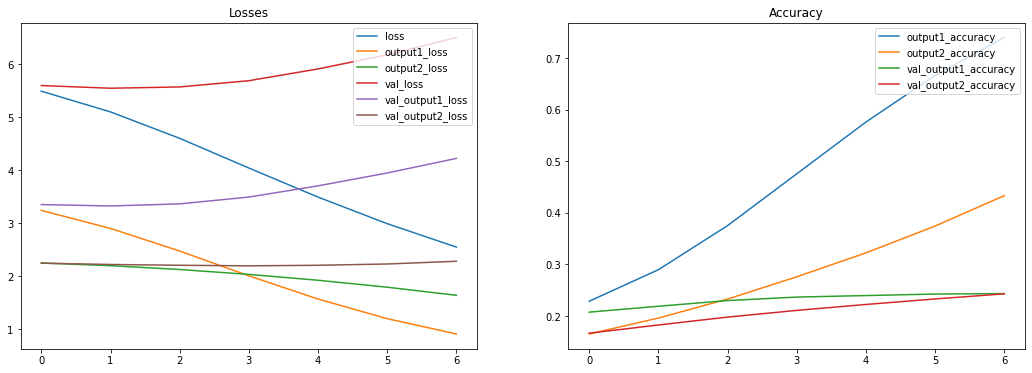

In [9]:
with open(loss_files[1], 'r') as fp:
    losses = pd.DataFrame(json.load(fp))

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
losses[[c for c in losses.columns if 'loss' in c]].plot(ax=ax1)
ax1.legend(loc='upper right')
ax1.set_title('Losses')
losses[[c for c in losses.columns if 'loss' not in c]].plot(ax=ax2)
ax2.legend(loc='upper right')
ax2.set_title('Accuracy')
plt.show()